In [84]:
import requests
import re
import os
from bs4 import BeautifulSoup
import pickle
import bz2file as bz2
from urllib.request import urlopen
from urllib.parse import quote
import statistics as stats
import pickle
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
import matplotlib.pyplot as plt
import community as community_louvain
from collections import Counter
from wordcloud import WordCloud
from fa2_modified import ForceAtlas2
import matplotlib.colors as mcolors
import math
import networkx as nx

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [85]:
baseUrl = "https://gameofthronesfanon.fandom.com/"

In [86]:
def save(title, data):
    with bz2.BZ2File(f"{title}.pbz2", "w") as f:
        pickle.dump(data, f)

In [87]:
def load(title):
    with bz2.BZ2File(f"{title}.pbz2", "r") as f:
        return pickle.load(f)

In [88]:
def fetch_page(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.text

In [89]:
def save_to_file(content, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(content)

In [90]:
# Get all urls for the characters
urls = []
for char in ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]:
     url = f"{baseUrl}wiki/Category:Characters?from={char}"
     urls.append(url)

In [91]:
# Get all characters from the Game of Thrones Fanon Wiki
if not os.path.exists('../data/all_characters.html'):   
    all_content = ""
    for url in urls:
        content = fetch_page(url)
        if content:
            all_content += content
        else:
            print(f"Failed to fetch {url}")

    save_to_file(all_content, '../data/all_characters.html')

In [92]:
class BiographicalInfo:
    def __init__(self, name, birth_year, birth_place):
        self.name = name
        self.birth_year = birth_year
        self.birth_place = birth_place
    
    def __repr__(self):
        return f"{self.name} was born in {self.birth_place} in {self.birth_year}"

In [93]:
class PoliticalInfo:
    def __init__(self, houses, titles):
        self.houses = houses
        self.titles = titles
    
    def __repr__(self):
        return f"{self.titles} of {self.houses}"

In [94]:
class PersonalInfo:
    def __init__(self, aka, culture, religon, father, mother, spouses, issues, siblings):
        self.aka = aka
        self.culture = culture
        self.religon = religon
        self.father = father
        self.mother = mother
        self.spouses = spouses
        self.issues = issues
        self.siblings = siblings
    
    def __repr__(self):
        return f"{self.aka} {self.culture} {self.religon} {self.father} {self.mother} {self.spouses} {self.issues} {self.siblings}"

In [95]:
class Character:
    def __init__(self, name, url, html, text):
        self.name = name
        self.url = url
        self.html = html
        self.text = text
        self.references = []
        self.biographical_info = None
        self.personal_info = None
        self.political_info = None
        self.sentiment = None
        self.tfidf = None

    def __repr__(self):
        return f"Character(name={self.name}, url={self.url})"

In [96]:
def get_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text(separator="\n", strip=True)
    return text

In [97]:
def get_html(url):
    content = fetch_page(url)
    return content

In [98]:
def create_character(name, url):
    text = get_text(url)
    html = get_html(url)
    character = Character(name, url, html, text)
    return character

In [99]:
def get_characters_from_matches(matches):
    skip = ["Category:", "User:"]
    characters = []
    for href, title in matches:
        if any(s in title for s in skip):
            continue
        try:
            character = create_character(title, baseUrl + href)
            characters.append(character)
        except Exception as e:
            pass

    return characters

In [100]:
def get_all_character_matches_of_html():
    with open('../data/all_characters.html', 'r', encoding='utf-8') as file:
        all_characters_html = file.read()
        pattern = r'<a\s+href="([^"]+)"\s+title="([^"]+)"'
        matches = re.findall(pattern, all_characters_html)
        return matches

In [101]:
# get all characters from the html file and add the text and raw html to the character
path = '../data/characters_1'
characters = []
if os.path.exists(f"{path}.pbz2"):
    characters = load(path)
else:    
    matches = get_all_character_matches_of_html()
    characters = get_characters_from_matches(matches)
    save(path, characters)

In [102]:
# add references to the characters
pattern = r'<a\s+href="([^"]+)"'
all_character_urls = [character.url for character in characters]
for character in characters:
    matches = re.findall(pattern, character.html)
    for href in matches:
        url = baseUrl + href
        if url in all_character_urls and url != character.url:
            reference = [c for c in characters if c.url == url][0]
            character.references.append(reference)

In [103]:
class CharacterAttribute:
    def __init__(self, data_source_title, texts):
        self.data_source_title = data_source_title
        self.texts = texts
        self.hrefs = []

    def __repr__(self):
        return f"{self.data_source_title} {self.texts} {self.hrefs}"

In [104]:
def get_by_data_source(character, data_source_title, tag):
    soup = BeautifulSoup(character.html, 'html.parser')
    result = soup.find(attrs={"data-source": data_source_title})
    if result:
        if tag is None:
            results = result
        else:
            results = result.findAll(tag)
        texts = [result.text for result in results]
        characterAttribute = CharacterAttribute(data_source_title, texts)
        if tag == "a":
            hrefs = [result['href'] for result in results]
            characterAttribute.hrefs = hrefs
        return characterAttribute
    return None

In [105]:
def get_name(character):
    return get_by_data_source(character, "Title", None)

In [106]:
def get_birth_year(character):
    return get_by_data_source(character, "Birth", "div")

In [107]:
def get_birth_place(character):
    return get_by_data_source(character, "Birth", "a")

In [108]:
def get_titles(character):
    return get_by_data_source(character, "Titles", "a")

In [109]:
def get_houses(character):
    return get_by_data_source(character, "House", "a")

In [110]:
def get_AKA(character):
    return get_by_data_source(character, "AKA", "div")

In [111]:
def get_culture(character):
    return get_by_data_source(character, "Culture", "a")

In [112]:
def get_religion(character):
    return get_by_data_source(character, "Religion", "a")

In [113]:
def get_father(character):
    return get_by_data_source(character, "Father", "a")

In [114]:
def get_mother(character):
    return get_by_data_source(character, "Mother", "a")

In [115]:
def get_spouses(character):
    return get_by_data_source(character, "Spouse", "div")

In [116]:
def get_issues(character):
    return get_by_data_source(character, "Issue", "a")

In [117]:
def get_siblings(character):
    return get_by_data_source(character, "Siblings", "a")

In [118]:
def get_character_bibliographical_info(character):
    name = get_name(character)
    birth_place = get_birth_place(character)
    birth_year = get_birth_year(character)
    return BiographicalInfo(name, birth_year, birth_place)

In [119]:
def get_political_info(character):
    houses = get_houses(character)
    titles = get_titles(character)
    return PoliticalInfo(houses, titles)

In [120]:
def get_personal_info(character):
    aka = get_AKA(character)
    culture = get_culture(character)
    religion = get_religion(character)
    father = get_father(character)
    mother = get_mother(character)
    spouses = get_spouses(character)
    issues = get_issues(character)
    siblings = get_siblings(character)
    return PersonalInfo(aka, culture, religion, father, mother, spouses, issues, siblings)

In [121]:
# add attributes to the characters
path = '../data/characters_2'
if os.path.exists(f"{path}.pbz2"):
    characters = load(path)
else:   
    for character in characters:
        character.biographical_info = get_character_bibliographical_info(character)
        character.political_info = get_political_info(character)
        character.personal_info = get_personal_info(character) 
    save(path, characters)

In [122]:
path = "../data/word_happines"
if not os.path.exists(f"{path}.pbz2"):
    url = "https://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2"

    limit = 1000 
    offset = 0 

    word_happiness_dict = {}

    while True:
        response = requests.get(url, params={"limit": limit, "offset": offset})
        
        if response.status_code == 200:
            data = response.json()
            
            for entry in data["objects"]:
                word_happiness_dict[entry["word"]] = entry["happs"]
            
            if data["meta"]["next"] is None:
                break  
            
            offset += limit
        else:
            print(f"Failed to retrieve data. Status code: {response.status_code}")
            break
    
    save(path, word_happiness_dict)
else:
    word_happiness_dict = load(path)

In [123]:
def get_tokens_for_sentiment(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    return tokens

In [124]:
def calculate_sentiment(tokens):
    tokens = [token for token in tokens if token in word_happiness_dict]
    return sum(word_happiness_dict[token] for token in tokens) / len(tokens)

In [125]:
def add_sentiment_to_characters():
    for character in characters:
        tokens = get_tokens_for_sentiment(character.text)
        sentiment = calculate_sentiment(tokens)
        character.sentiment = sentiment

In [126]:
def get_tokens_for_tfidf(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [127]:
def get_tf_dict(characters):
    tf_dict = {}
    for character in characters:
        tokens = get_tokens_for_tfidf(character.text)
        tf_dict_inner = {}
        for token in tokens:
            if token not in tf_dict_inner:
                tf_dict_inner[token] = 1
            else:
                tf_dict_inner[token] += 1
        tf_dict[character] = tf_dict_inner
    return tf_dict

In [128]:
def get_idf_dict(tf_dict):
    token_counts = {}

    for _, tf_dict_inner in tf_dict.items():
        unique_tokens = set(tf_dict_inner.keys())
        for token in unique_tokens:
            if token not in token_counts:
                token_counts[token] = 1
            else:
                token_counts[token] += 1

    idf_dict = {}
    for token, count in token_counts.items():
        idf_dict[token] = math.log(len(characters) / count)
    
    return idf_dict

In [129]:
def add_tfidf_to_characters(tf_dict, idf_dict):
    for character, tf_dict_inner in tf_dict.items():
        tfidf_dict_inner = {}
        for token, count in tf_dict_inner.items():
            tfidf_dict_inner[token] = count * idf_dict[token]
        character.tfidf = sorted(tfidf_dict_inner.items(), key=lambda x: x[1], reverse=True)

In [130]:
path = '../data/characters_3'
if os.path.exists(f"{path}.pbz2"):
    characters = load(path)
else:   
    add_sentiment_to_characters()
    tf_dict = get_tf_dict(characters)
    idf_dict = get_idf_dict(tf_dict)
    add_tfidf_to_characters(tf_dict, idf_dict)
    save(path, characters)

In [131]:
G = nx.DiGraph()
G.add_nodes_from(characters)
for character in characters:
    edges = [(character, other) for other in character.references]
    G.add_edges_from(edges)

In [132]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 897
Number of edges: 18908


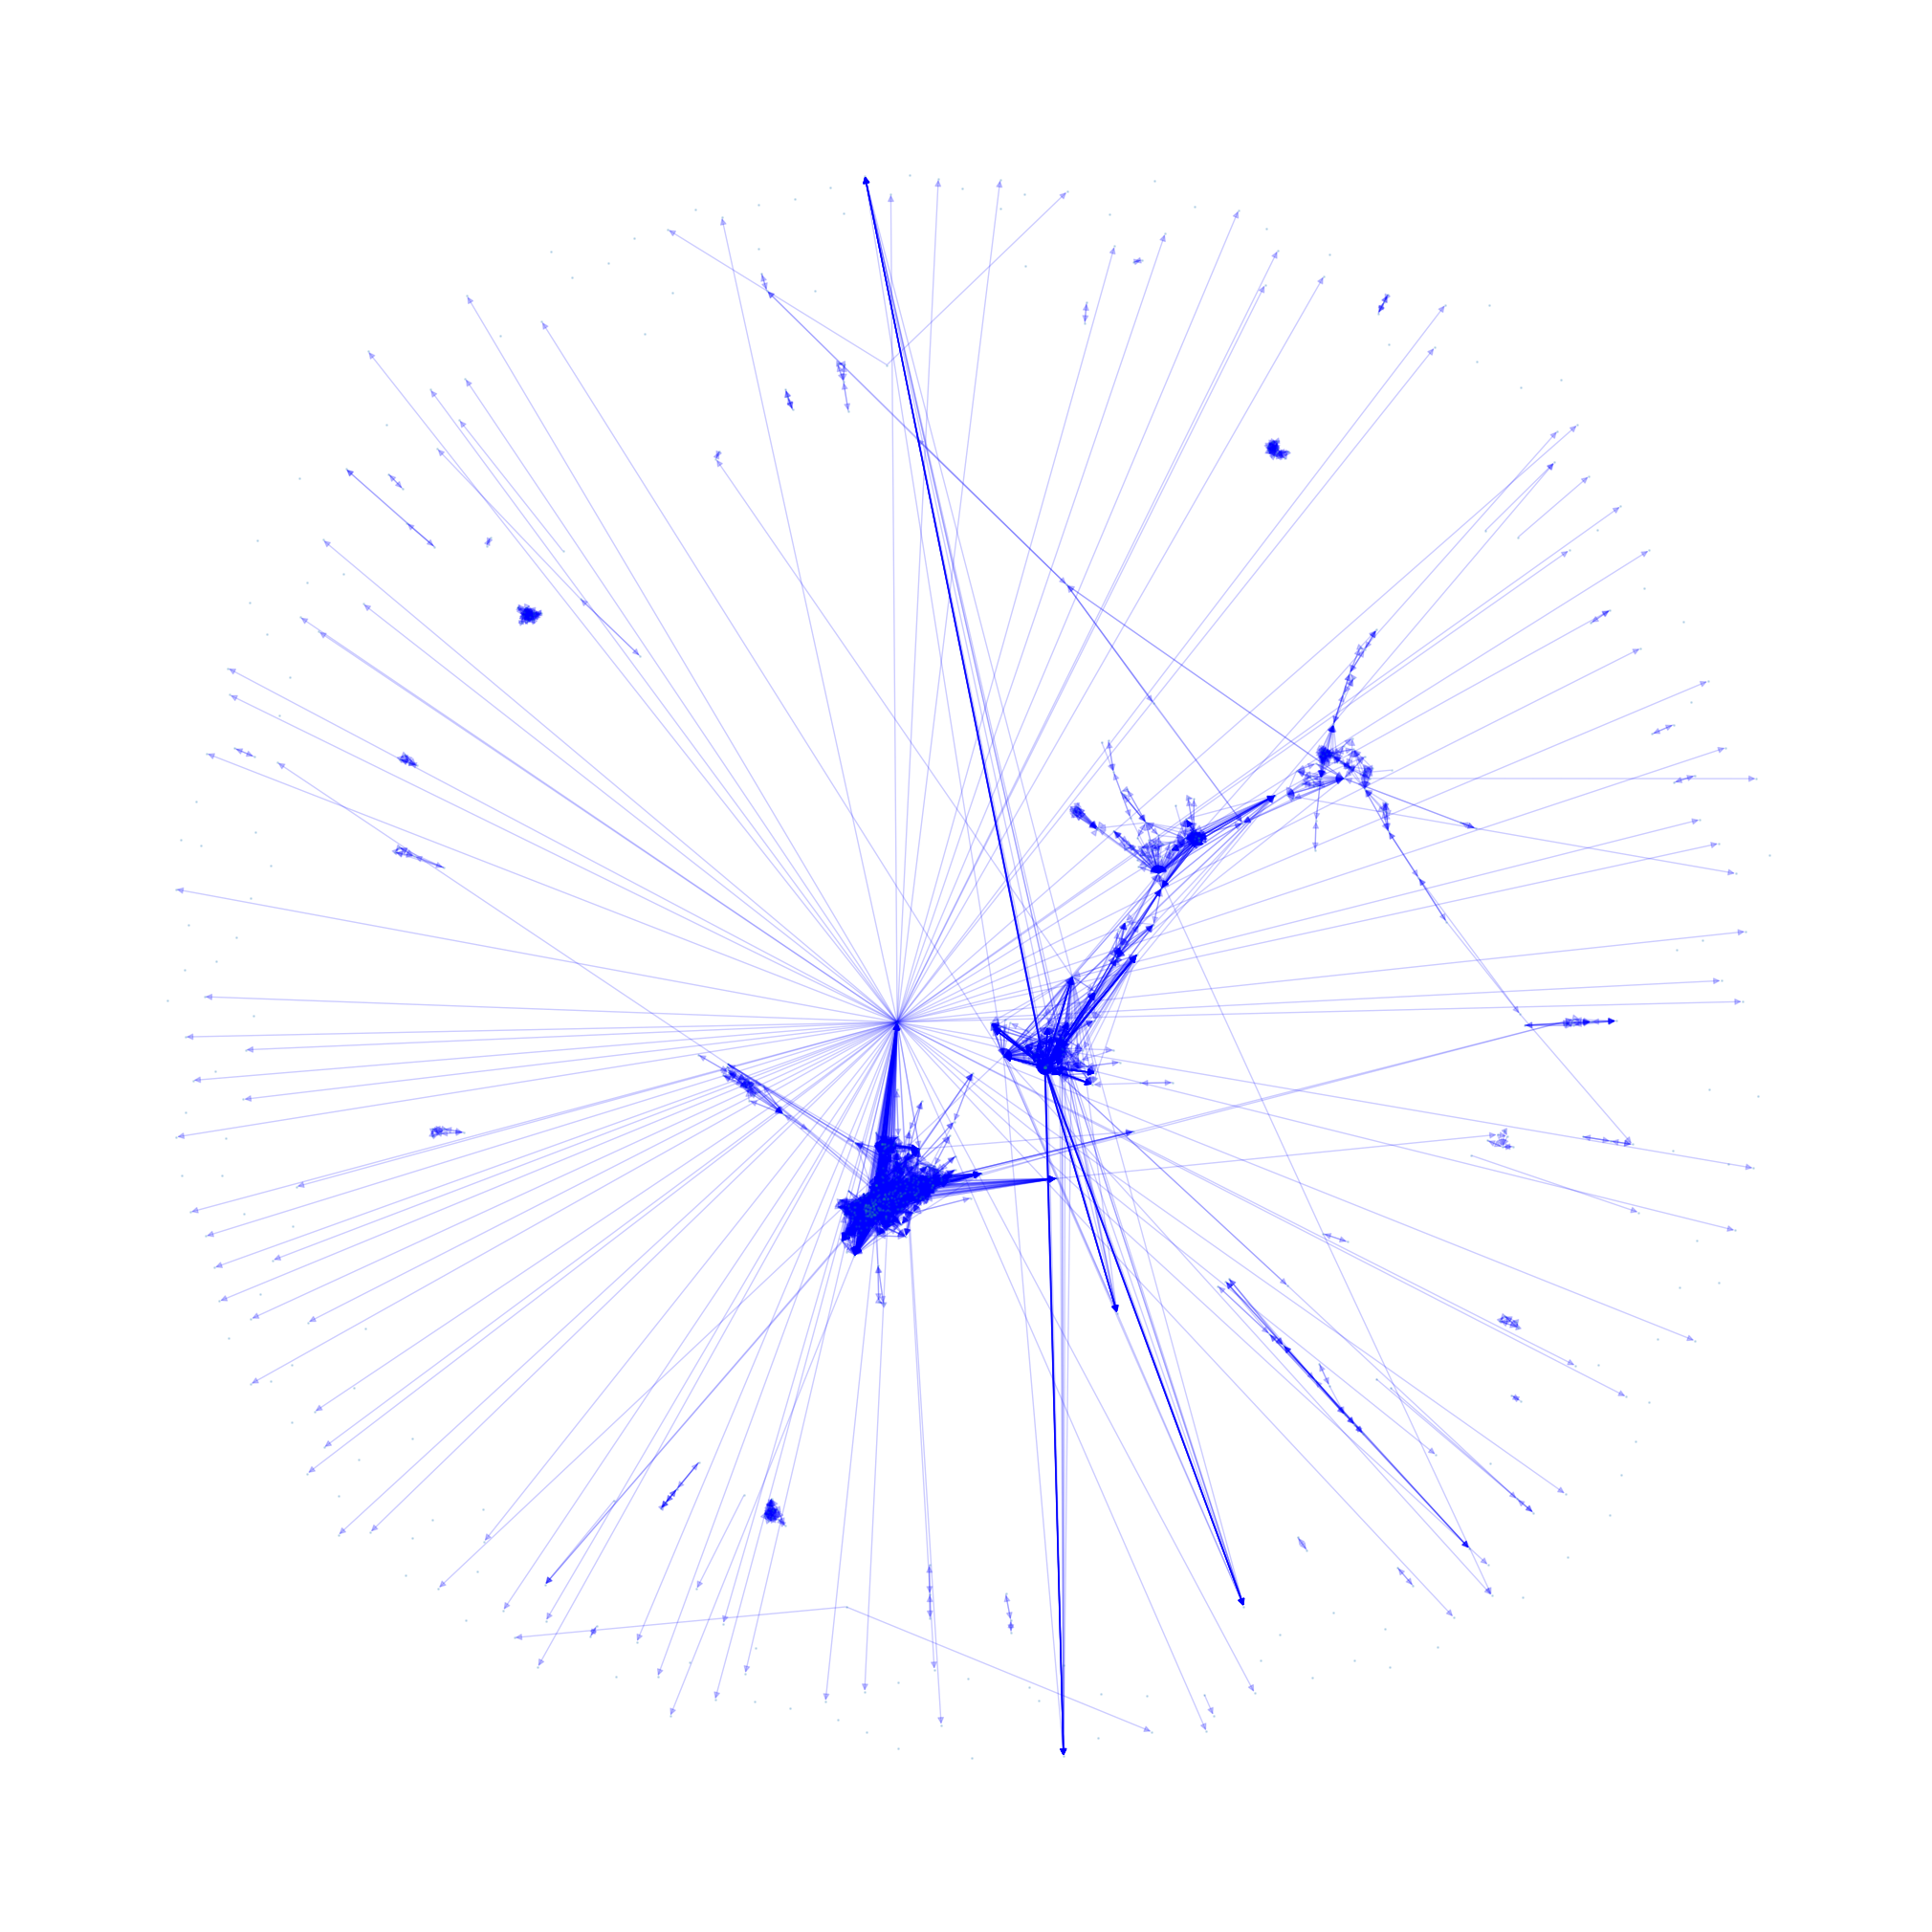

In [133]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=1, edge_color="b", alpha=0.2, font_size=10, with_labels=False)
plt.show()

In [134]:
# most connected 
print("Most connected characters:")
sorted_on_degree = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)
for character in sorted_on_degree:
    print(f"{character} - {G.degree(character)}")

Most connected characters:
Character(name=Helaena Targaryen (Tales of Westeros: War for the Crown), url=https://gameofthronesfanon.fandom.com//wiki/Helaena_Targaryen_(Tales_of_Westeros:_War_for_the_Crown)) - 266
Character(name=Alyssa Targaryen (Tales of Westeros: War for the Crown), url=https://gameofthronesfanon.fandom.com//wiki/Alyssa_Targaryen_(Tales_of_Westeros:_War_for_the_Crown)) - 262
Character(name=Alysanne Targaryen (Tales of Westeros: War for the Crown), url=https://gameofthronesfanon.fandom.com//wiki/Alysanne_Targaryen_(Tales_of_Westeros:_War_for_the_Crown)) - 256
Character(name=Jon Stark (War of the Three Claims), url=https://gameofthronesfanon.fandom.com//wiki/Jon_Stark_(War_of_the_Three_Claims)) - 256
Character(name=Meriahyna Targaryen (Tales of Westeros: War for the Crown), url=https://gameofthronesfanon.fandom.com//wiki/Meriahyna_Targaryen_(Tales_of_Westeros:_War_for_the_Crown)) - 255
Character(name=Aegon II Targaryen (Tales of Westeros: War for the Crown), url=https://

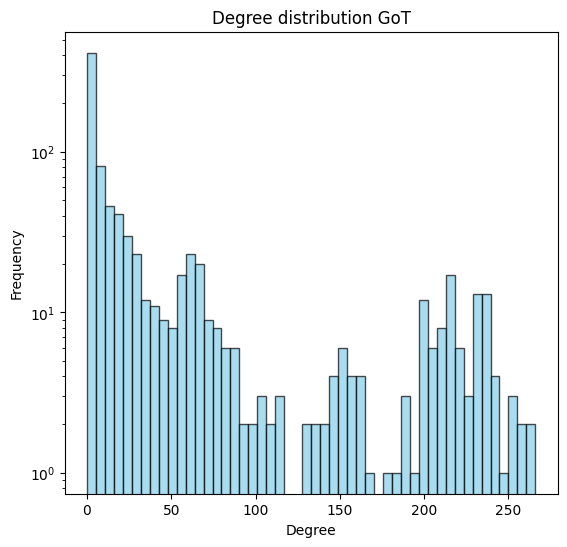

In [135]:
def plot_degree_distribution(G, title, color):
    degrees = [d for _, d in G.degree()]
    plt.hist(degrees, bins=50, color=color, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.yscale('log')

fig = plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_degree_distribution(G, "Degree distribution GoT", 'skyblue')

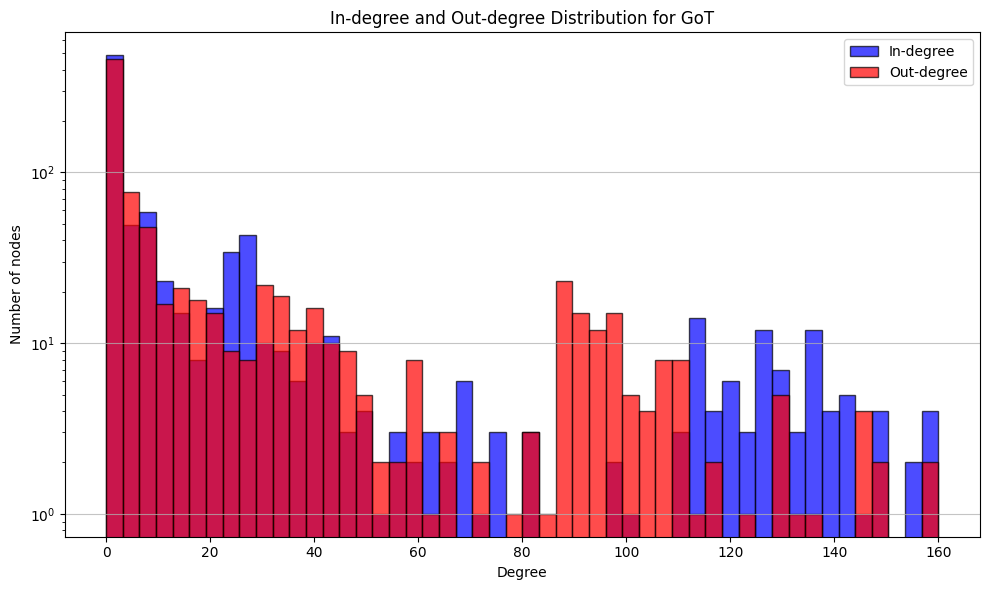

In [136]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

plt.figure(figsize=(10, 6))

plt.hist(in_degrees, bins=50, alpha=0.7, color='blue', edgecolor='black', label="In-degree")

plt.hist(out_degrees, bins=50, alpha=0.7, color='red', edgecolor='black', label="Out-degree")

plt.title("In-degree and Out-degree Distribution for GoT")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")

plt.legend()

plt.yscale('log')

plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()


In [137]:
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

size_in_bytes = get_size(characters)

size_in_mb = size_in_bytes / (1024 * 1024)
print(f"Size of characters list: {size_in_mb:.2f} MB")

Size of characters list: 571.41 MB


In [139]:
sentiments = [character.sentiment for character in characters if character.sentiment is not None]
mean = stats.mean(sentiments)
median = stats.median(sentiments)
std = stats.stdev(sentiments)
quantiles = stats.quantiles(sentiments, n=4)
print("Mean:", round(mean, 3))
print("Median:", round(median, 3))
print("Std. dev:", round(std, 3))
print("25th quantile", round(quantiles[0], 3))
print("75th quantile", round(quantiles[2], 3))

Mean: 5.544
Median: 5.565
Std. dev: 0.103
25th quantile 5.476
75th quantile 5.623


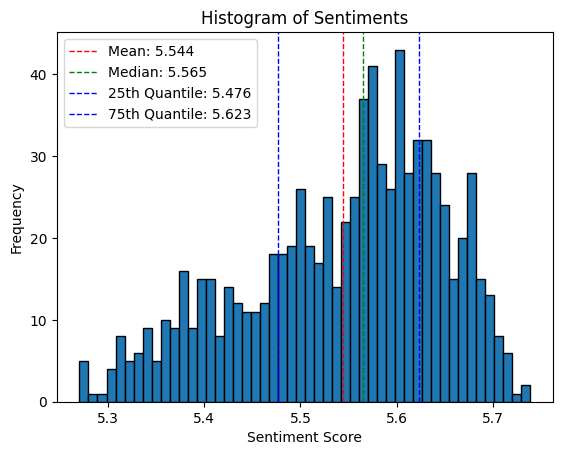

In [140]:
plt.hist(sentiments, bins=50, edgecolor='black')
plt.title('Histogram of Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.3f}')
plt.axvline(median, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median:.3f}')
plt.axvline(quantiles[0], color='b', linestyle='dashed', linewidth=1, label=f'25th Quantile: {quantiles[0]:.3f}')
plt.axvline(quantiles[2], color='b', linestyle='dashed', linewidth=1, label=f'75th Quantile: {quantiles[2]:.3f}')

plt.legend()
plt.show()

In [141]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=False)

In [149]:
G = G.to_undirected()
partition = community_louvain.best_partition(G)

community_counts = Counter(partition.values())
most_common_communities = community_counts.most_common(10)
common_community_ids = set(community[0] for community in most_common_communities)

colors = list(mcolors.TABLEAU_COLORS.keys())
community_colors = {community_id: colors[i % len(colors)] for i, community_id in enumerate(common_community_ids)}

node_colors = []
for node in G.nodes():
    community_id = partition[node]
    if community_id in community_colors:
        node_colors.append(community_colors[community_id])
    else:
        node_colors.append('lightgray')

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

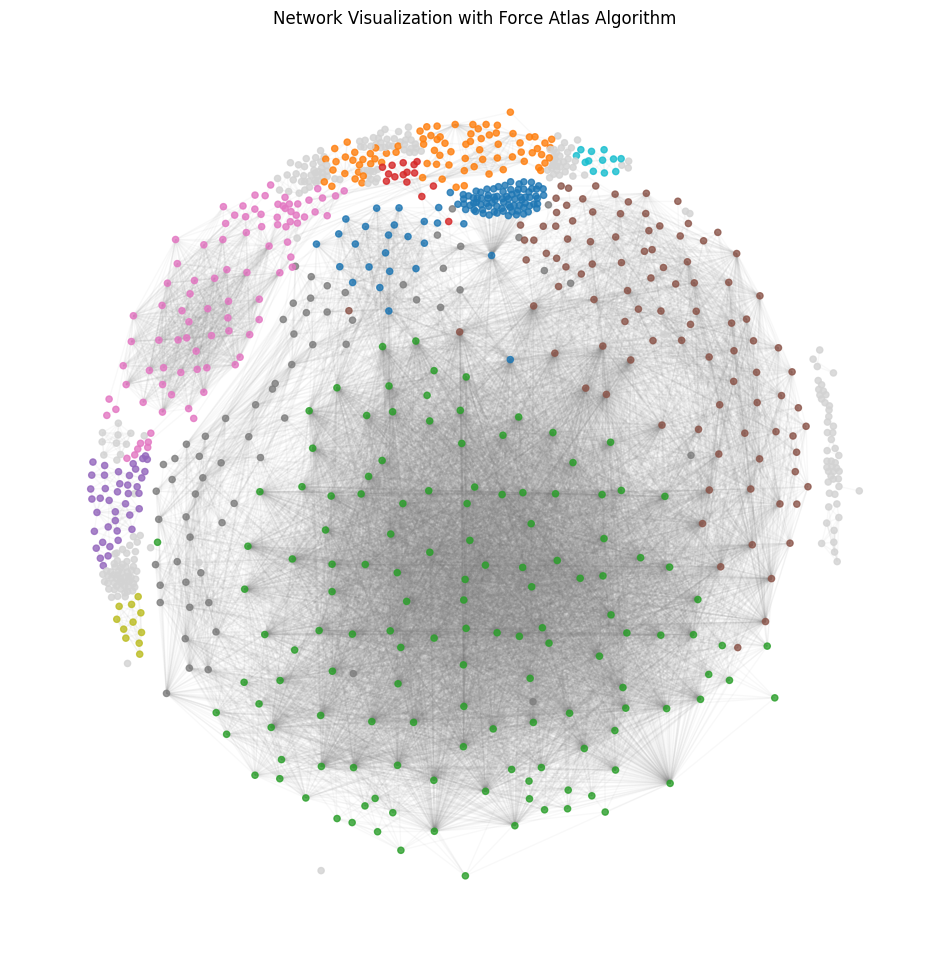

In [150]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, positions, node_size=20, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, positions, edge_color="gray", alpha=0.05)
plt.axis('off')
plt.title("Network Visualization with Force Atlas Algorithm")
plt.show()